In [44]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [45]:
def plot_images(images, offset, length):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if length > 10: length = 10
    for i in range(0, length):
        ax = plt.subplot(2, 5, 1+i)
        ax.imshow(images[offset], cmap='binary')
        
        ax.set_xticks([]);
        ax.set_yticks([]);
        offset += 1
    plt.show()

In [46]:
# Read all images in list.
handwrite0 = '/Users/PChomeIM/uploads/0.png'
handwrite1 = '/Users/PChomeIM/uploads/1.png'
handwrite3 = '/Users/PChomeIM/uploads/3.png'
handwrite_images = [handwrite0, handwrite1, handwrite3]

# https://www.tensorflow.org/api_docs/python/tf/train/string_input_producer
# Make a queue of file names including all the images 
# default shuffle = True, If true, the strings are randomly shuffled within each epoch.
filename_queue = tf.train.string_input_producer(handwrite_images, shuffle=False)

# https://www.tensorflow.org/api_docs/python/tf/WholeFileReader
# To use, enqueue filenames in a Queue. 
# The output of Read will be a filename (key) and the contents of that file (value).
reader = tf.WholeFileReader()
# reader.read: Returns the next record (key, value pair) produced by a reader.
key, value = reader.read(filename_queue)

# https://www.tensorflow.org/versions/r0.12/api_docs/python/image/encoding_and_decoding
# The encode and decode Ops apply to one image at a time.
# If you need fixed size images, pass the output of the decode Ops to one of the cropping and resizing Ops.
# channels=1: output a grayscale image.
# channels=3: output an RGB image.
myimg = tf.image.decode_png(value, channels=1)
crop_myimg = tf.image.resize_image_with_crop_or_pad(myimg, 135, 135) #置中裁減
resize_myimg = tf.image.resize_images(crop_myimg, [28, 28]) #調整大小

In [47]:
# The TensorFlow Session object is multithreaded and thread-safe, 
# so multiple threads can easily use the same session and run ops in parallel.
with tf.Session() as sess:
    # Return an Op that initializes global variables in the graph.
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # http://www.jianshu.com/p/d063804fb272
    # https://www.tensorflow.org/programmers_guide/threading_and_queues
    # The Coordinator class helps multiple threads stop together and report exceptions to a program that waits for them to stop. 
    # The QueueRunner class is used to create a number of threads cooperating to enqueue tensors in the same queue.
    # These two classes are designed to be used together. 
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Collect all images tensor
    all_images = []
    
    # Main thread, consumes all job.
    for i in range(len(handwrite_images)):
        '''
        The difference is in Operations and Tensors. 
        Operations use run() and Tensors use eval().
        In this example, resize_myimg is a tensor.
        And tensor.eval() is equivalent to sess.run(tensor).
        ''' 
        image = resize_myimg.eval() # is equivalent to sess.run(resize_myimg)
        reshape_image = image.reshape(image.shape[0], image.shape[1])
        abs_image = abs(255-reshape_image)
        all_images.append(abs_image)
        #print(abs_image.shape)
        #print(abs_image)
        
    # Convert list to numpy array format
    all_images = np.array(all_images, dtype=np.int16)
    print(all_images.shape)
    
    # Save train data to binary format
    all_images.tofile('train.dat')

    # When done, ask the threads to stop.
    coord.request_stop()
    # And wait for threads actually stop.
    coord.join(threads)

(3, 28, 28)


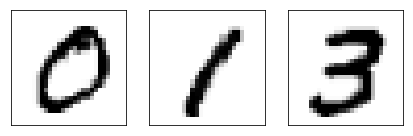

In [48]:
plot_images(all_images, 0, all_images.shape[0])